# Import Modules

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix

### Used for importing the model
import urllib.request
import tarfile
import zipfile
import sys
import os
import pickle
import random

from IPython.display import Image, display

# Define Key Values

In [7]:
# Define Model
model_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
model_directory = "inception"
map_id_to_class  = "imagenet_2012_challenge_label_map_proto.pbtxt"
map_id_to_name = "imagenet_synset_to_human_label_map.txt"
map_graph_def = "classify_image_graph_def.pb"

bottleneck_tensor_name = 'pool_3:0'
jpeg_tensor_name = 'DecodeJpeg/contents:0'
jpeg_tensor_input_name = 'DecodeJpeg:0'
resized_input_tensor_name = 'ResizeBilinear:0'
softmax_tensor_name = "softmax:0"
softmax_tensor_logits_name = 'softmax/logits:0'

# Define Dataset
data_directory = "/256_ObjectCategories/"
image_size = 32
num_channels = 3
num_classes= 257

In [8]:
def download(url, directory):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = url.split('/')[-1]
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
    
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' %
                           (filename,
                            float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
    
        filepath, _ = urllib.request.urlretrieve(url,filepath,  _progress)
        print()
        statinfo = os.stat(filepath)
    else:
        print('File already downloaded')
    tarfile.open(filepath, 'r:gz').extractall(directory)

# Map ImageNet Class IDs to Names

In [9]:
_uid_to_cls = {}   # Map from uid to cls.
_uid_to_name = {}  # Map from uid to name.
_cls_to_uid = {}   # Map from cls to uid.

path = os.path.join(model_directory, map_id_to_name)
with open(file=path, mode='r') as file:
    # Read all lines from the file.
    lines = file.readlines()

    for line in lines:
        # Remove newlines.
        line = line.replace("\n", "")

        # Split the line on tabs.
        elements = line.split("\t")

        # Get the uid.
        uid = elements[0]

        # Get the class-name.
        name = elements[1]

        # Insert into the lookup-dict.
        _uid_to_name[uid] = name

# Read the uid-to-cls mappings from file.
path = os.path.join(model_directory, map_id_to_class)
with open(file=path, mode='r') as file:
    # Read all lines from the file.
    lines = file.readlines()

    for line in lines:
        # We assume the file is in the proper format,
        # so the following lines come in pairs. Other lines are ignored.

        if line.startswith("  target_class: "):
            # This line must be the class-number as an integer.

            # Split the line.
            elements = line.split(": ")

            # Get the class-number as an integer.
            cls = int(elements[1])

        elif line.startswith("  target_class_string: "):
            # This line must be the uid as a string.

            # Split the line.
            elements = line.split(": ")

            # Get the uid as a string e.g. "n01494475"
            uid = elements[1]

            # Remove the enclosing "" from the string.
            uid = uid[1:-2]

            # Insert into the lookup-dicts for both ways between uid and cls.
            _uid_to_cls[uid] = cls
            _cls_to_uid[cls] = uid

# Build Graph

In [10]:
graph = tf.Graph()
  
learning_rate = 0.01

with graph.as_default():

    #path = model_directory + "/" + map_graph_def
    path = os.path.join(model_directory, map_graph_def)
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def = tf.GraphDef()

        graph_def.ParseFromString(file.read())

        #remember to set name to empty string else it doesn't work
        tf.import_graph_def(graph_def, name='')

In [11]:
# Get the output of the Inception model by looking up the tensor
# with the appropriate name for the output of the softmax-classifier.
y_output = graph.get_tensor_by_name(softmax_tensor_name)

# Get the unscaled outputs for the Inception model (aka. softmax-logits).
y_logits = graph.get_tensor_by_name(softmax_tensor_logits_name)

# Get the tensor for the resized image that is input to the neural network.
resized_image = graph.get_tensor_by_name(resized_input_tensor_name)

# Get the tensor for the last layer of the graph, aka. the transfer-layer.
bottleneck_layer = graph.get_tensor_by_name(bottleneck_tensor_name)

# Get the number of elements in the transfer-layer.
bottleneck_length = bottleneck_layer.get_shape()[3]

# Create a TensorFlow session for executing the graph.
session = tf.Session(graph=graph)

# Helper Functions

In [12]:
def predictClass(image_path):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
        
    prediction = session.run(y_output, feed_dict={jpeg_tensor_name: image_data})

    return np.squeeze(prediction)

In [13]:
def calculateScore(predictions, amount):
    #sorting the predictions
    prediction_args_sorted = predictions.argsort()
    prediction_percent = np.sort(predictions)[:amount:-1]
    topWinners = prediction_args_sorted[::-1]
    i=0
    for winner in topWinners[:amount]:
        uid = _cls_to_uid[winner]
        name = _uid_to_name[uid].split(",")[0]
        print('%.4f' % prediction_percent[i] + " " + name)
        i+=1

In [14]:
def classify(image_path, amount):
    image_path = os.path.join(model_directory, image_path)
    display(Image(image_path))
    calculateScore(predictClass(image_path), amount)

In [15]:
def getBottleneckValues(image_path):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    bottleneck_values = session.run(bottleneck_layer, feed_dict={jpeg_tensor_name: image_data})

    return np.squeeze(bottleneck_values)

# Make Predictions

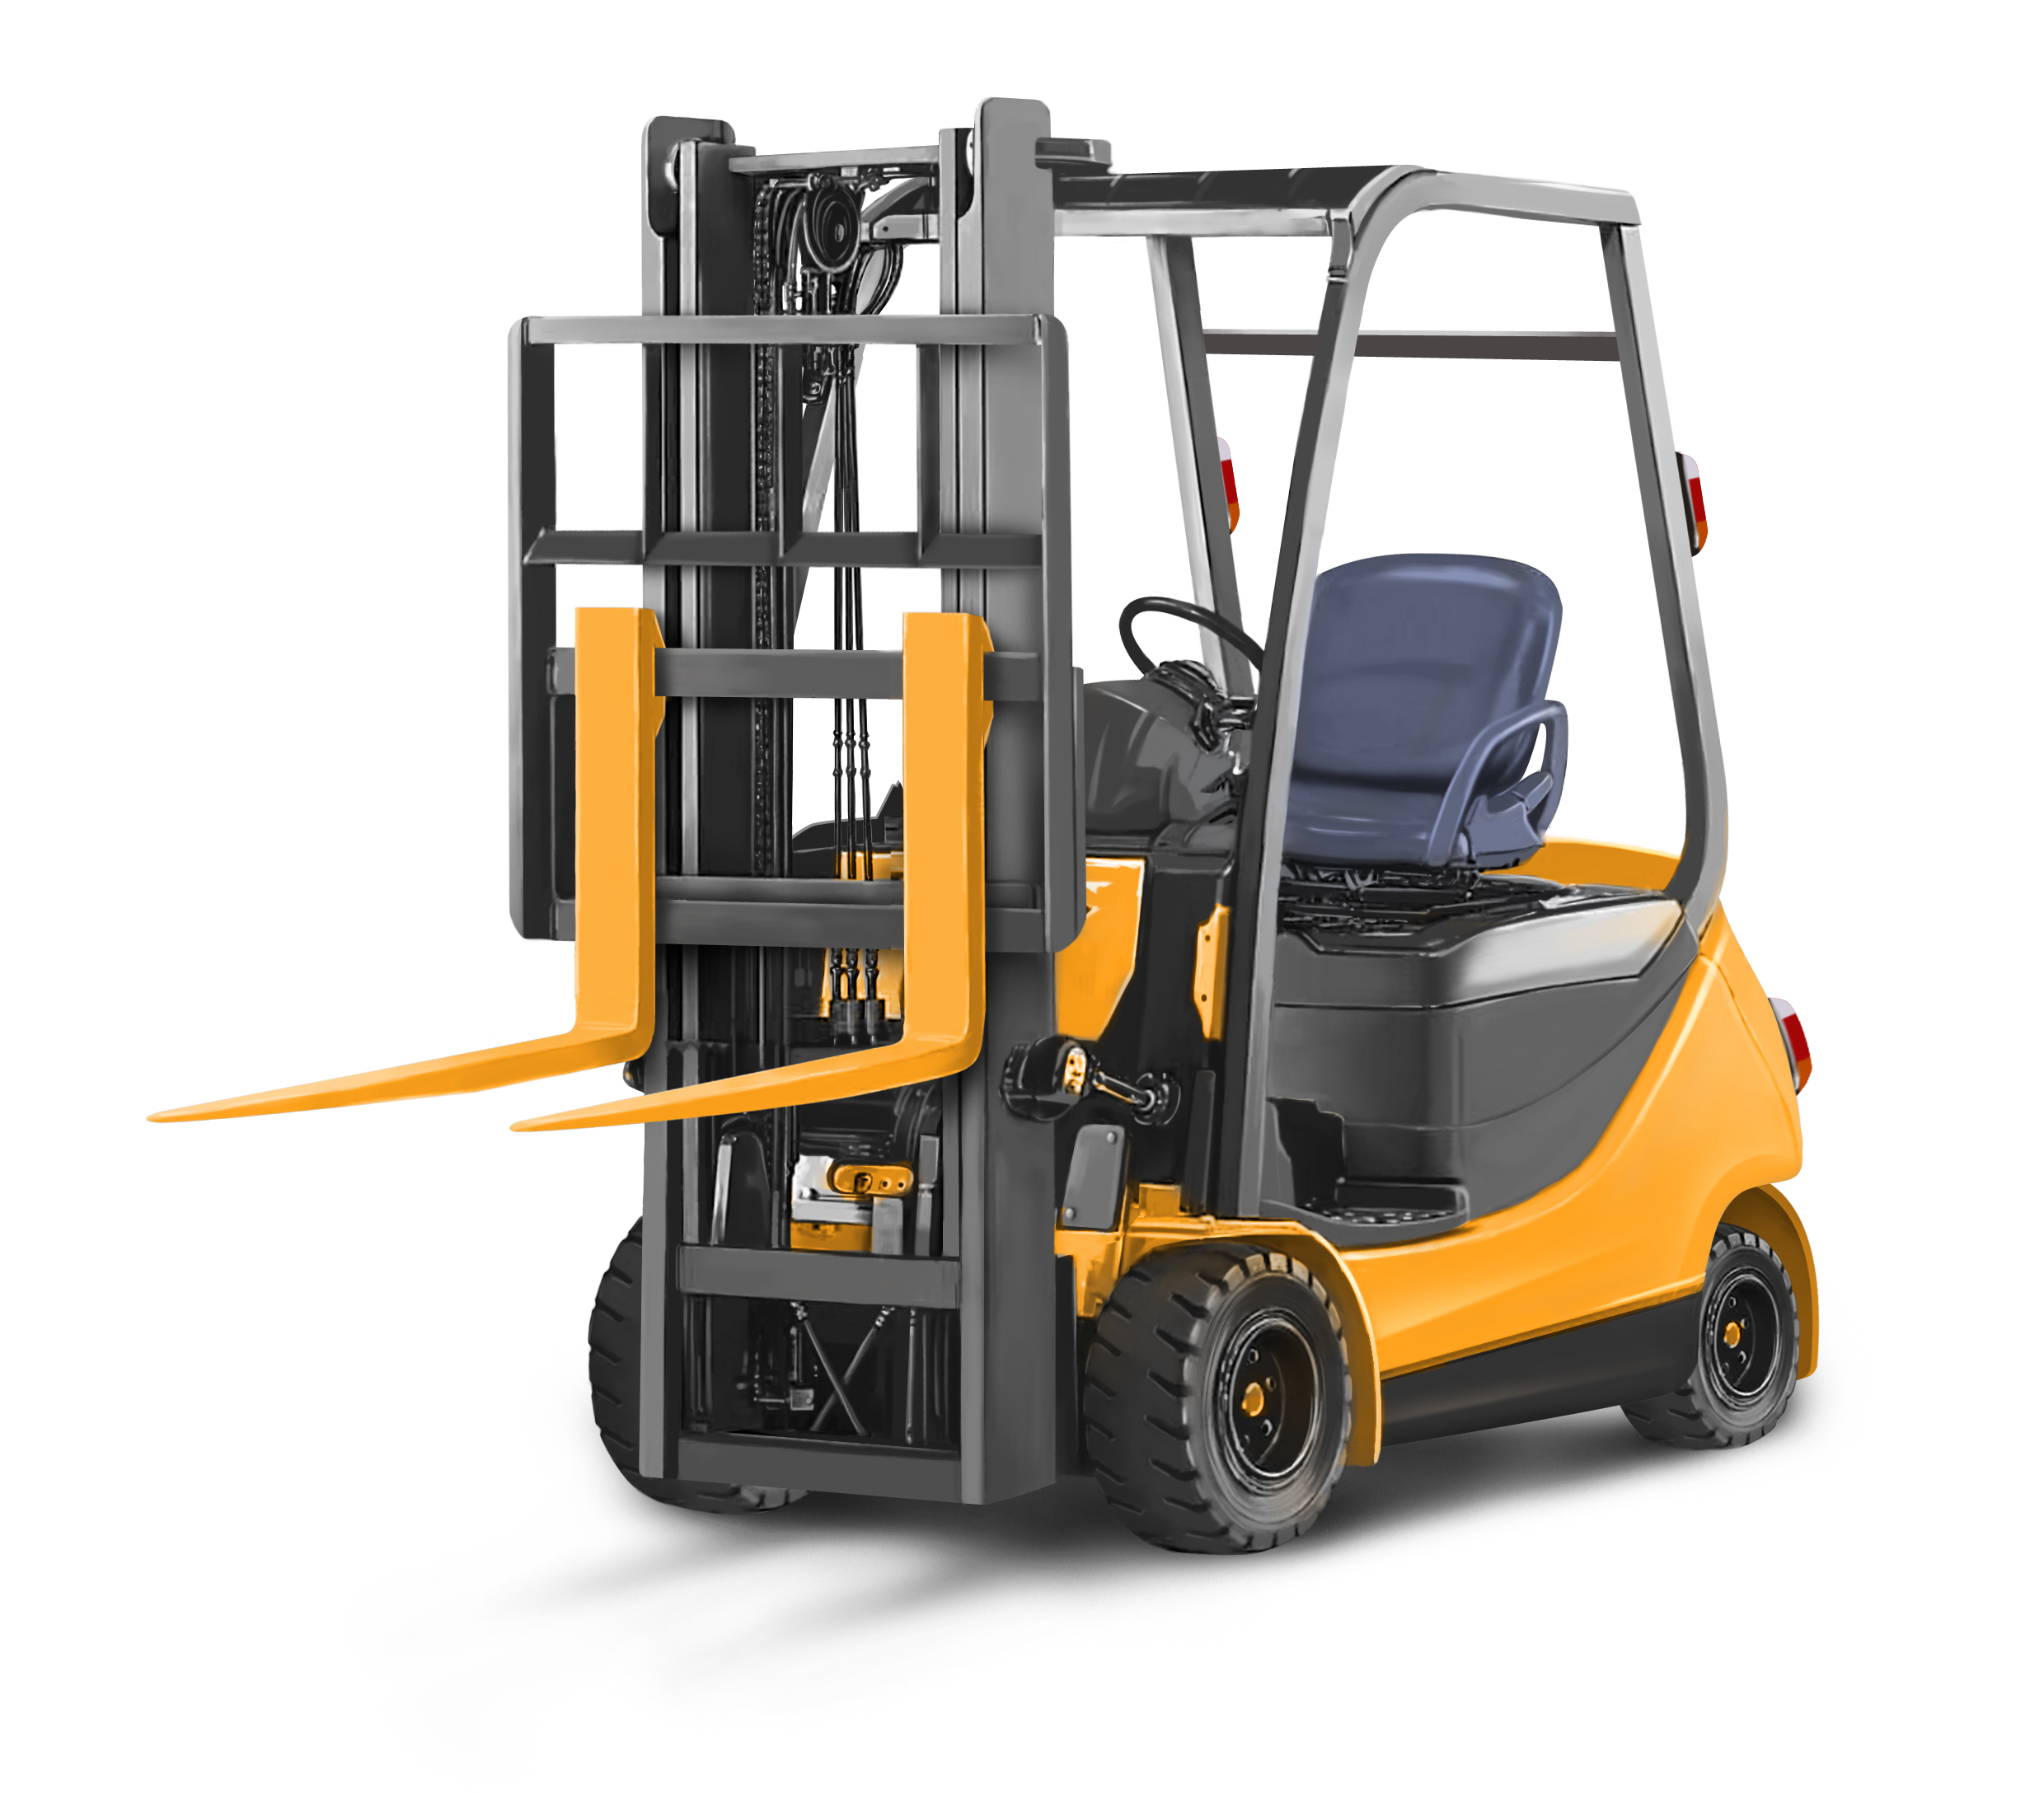

0.9826 forklift
0.0002 barbell


In [16]:
classify('Forklift-Truck.jpg', 2)

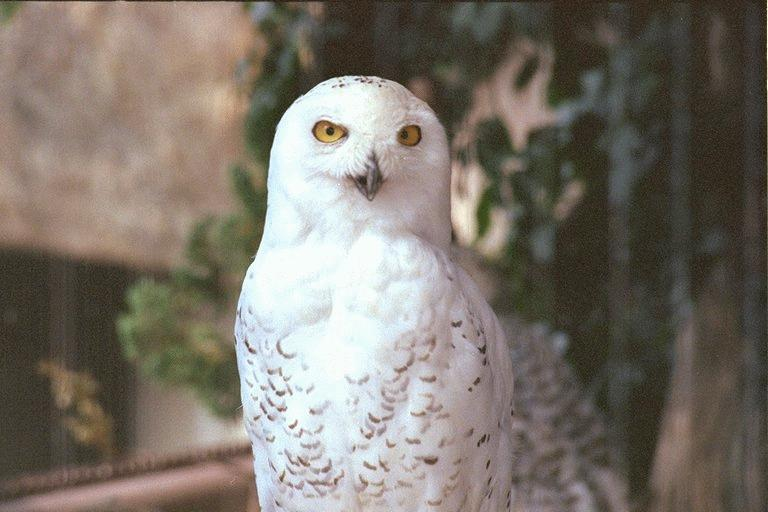

0.3321 sulphur-crested cockatoo
0.2836 kite


In [17]:
something = classify('birds/'+'owl/owl004.jpg', amount=2)

In [18]:
def bottleneckCache(cache_path, images=None, image_paths=None):

    if os.path.exists(cache_path):
    # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            bottleneck_values = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        bottleneck_values = process_images(images=images, image_paths=image_paths)
        try:
        # Save the data to a cache-file.
            with open(cache_path, mode='wb') as file:
                pickle.dump(bottleneck_values, file)
        except EOFError:
            return {}
        print("- Data saved to cache-file: " + cache_path)

    return bottleneck_values

In [19]:
def process_images(images=None, image_paths=None):
    """
    Call the function fn() for each image, e.g. transfer_values() from
    the Inception model above. All the results are concatenated and returned.
    :param fn:
        Function to be called for each image.
    :param images:
        List of images to process.
    :param image_paths:
        List of file-paths for the images to process.
    :return:
        Numpy array with the results.
    """

    # Are we using images or image_paths?
    using_images = images is not None

    # Number of images.
    if using_images:
        num_images = len(images)
    else:
        num_images = len(image_paths)


    result = [None] * num_images

    # For each input image.
    for i in range(num_images):

        result[i] = getBottleneckValues(image_path=os.path.abspath(model_directory + data_directory+image_paths[i]))

    return  np.array(result)


In [20]:
if not os.path.exists(model_directory + '/MaleFemaleFaces/Female'):
    print("Wrong")
else:
    print("Exists!")
femaleBottlenecks = getBottleneckValues(image_path=os.path.abspath(model_directory + '/MaleFemaleFaces/Female/nm0000002_rm81958912_1924-9-16_2005.jpg'))

Exists!


In [21]:
def list_files(dire):
    r= []
    for root, dirs, files in os.walk(dire):
        if dirs:
            names = dirs
        for name in files:
            r.append((root.split(os.path.sep)[-1] + "/" + name, root.split(os.path.sep)[-1]))
    return r, names

In [22]:
r, label_names = list_files(os.path.abspath(model_directory + data_directory))

images = [x[0] for x in r]
labels = [x[1] for x in r]
print(label_names)

['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '058.doorknob', '059.drinking-straw', '060.du

In [23]:
img = images[:10000]
labels = labels[:10000]

In [24]:
out = bottleneckCache(cache_path=os.path.abspath('cacheStuff3.pkl'),image_paths=img)

c = list(zip(images, labels, out))

random.shuffle(c)
images, labels, out = zip(*c)

#random.shuffle(labels)
#need to separate into validation and training

- Data loaded from cache-file: C:\Users\Seth\CNNTutorials\5. TransferLearning_Tutorial\cacheStuff3.pkl


In [25]:
mydict = {}
label_names
i=0
for name in label_names:
    mydict[name] = i
    i += 1

In [26]:
def labelNamesToValues(labels):
    list_of_labels = []
    one_hot_labels = [0] * len(mydict.values())
    for label in labels:
        new_list = one_hot_labels[:]
        print(label)
        new_list[mydict[label]] = 1
        list_of_labels.append(new_list)
        
    return list_of_labels

In [27]:
label_values = labelNamesToValues(labels)

061.dumb-bell
032.cartman
067.eyeglasses
061.dumb-bell
080.frog
003.backpack
051.cowboy-hat
069.fighter-jet
019.boxing-glove
079.frisbee
074.flashlight
054.diamond-ring
021.breadmaker
001.ak47
046.computer-monitor
006.basketball-hoop
011.billiards
011.billiards
020.brain-101
043.coin
028.camel
042.coffin
008.bathtub
013.birdbath
032.cartman
046.computer-monitor
025.cactus
049.cormorant
005.baseball-glove
009.bear
022.buddha-101
032.cartman
059.drinking-straw
005.baseball-glove
057.dolphin-101
038.chimp
004.baseball-bat
085.goat
079.frisbee
005.baseball-glove
046.computer-monitor
032.cartman
068.fern
081.frying-pan
034.centipede
043.coin
003.backpack
006.basketball-hoop
005.baseball-glove
032.cartman
015.bonsai-101
022.buddha-101
023.bulldozer
017.bowling-ball
065.elk
092.grapes
044.comet
065.elk
001.ak47
043.coin
061.dumb-bell
092.grapes
047.computer-mouse
087.goldfish
073.fireworks
004.baseball-bat
065.elk
045.computer-keyboard
090.gorilla
051.cowboy-hat
042.coffin
008.bathtub
029.can

In [28]:
label_names

['001.ak47',
 '002.american-flag',
 '003.backpack',
 '004.baseball-bat',
 '005.baseball-glove',
 '006.basketball-hoop',
 '007.bat',
 '008.bathtub',
 '009.bear',
 '010.beer-mug',
 '011.billiards',
 '012.binoculars',
 '013.birdbath',
 '014.blimp',
 '015.bonsai-101',
 '016.boom-box',
 '017.bowling-ball',
 '018.bowling-pin',
 '019.boxing-glove',
 '020.brain-101',
 '021.breadmaker',
 '022.buddha-101',
 '023.bulldozer',
 '024.butterfly',
 '025.cactus',
 '026.cake',
 '027.calculator',
 '028.camel',
 '029.cannon',
 '030.canoe',
 '031.car-tire',
 '032.cartman',
 '033.cd',
 '034.centipede',
 '035.cereal-box',
 '036.chandelier-101',
 '037.chess-board',
 '038.chimp',
 '039.chopsticks',
 '040.cockroach',
 '041.coffee-mug',
 '042.coffin',
 '043.coin',
 '044.comet',
 '045.computer-keyboard',
 '046.computer-monitor',
 '047.computer-mouse',
 '048.conch',
 '049.cormorant',
 '050.covered-wagon',
 '051.cowboy-hat',
 '052.crab-101',
 '053.desk-globe',
 '054.diamond-ring',
 '055.dice',
 '056.dog',
 '057.dol

In [29]:
train_x = out[:7000]
train_y = label_values[:7000]
validation_x = out[7000:9999]
validation_y = label_values[7000:9999]

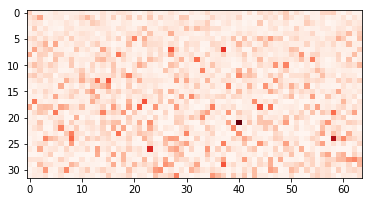

In [30]:
img = r[0]


img = out[0]

img = img.reshape((32, 64))

plt.imshow(img, interpolation='nearest', cmap='Reds')
plt.show()

# New Layers

In [31]:
with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, bottleneck_length])
    y_output = tf.placeholder(tf.float32, shape=[None, num_classes])
    y_output_class = tf.argmax(y_output, dimension=1)

    with tf.variable_scope('newfc'):
        weights = tf.get_variable('weights', shape=[bottleneck_length, num_classes],
                                 initializer = tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[num_classes], initializer=tf.constant_initializer(0))

        matrix_multiply = tf.matmul(x_input, weights)

        y_out = tf.nn.bias_add(matrix_multiply, biases)
    y_class = tf.nn.softmax(logits=y_out)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_output, logits=y_out)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y_output,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_mean)

### Optimizer

In [32]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """

    p = session.run([y_out], feed_dict = {x_input : out})

    return p

In [33]:
import time
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [34]:
import copy
def batch(x_data,y_data=None, batches=1):
    x_temp = copy.deepcopy(x_data)
    y_temp = copy.deepcopy(y_data)
    length = len(x_temp)
    
    # return iterations
    for index in range(0, length, batches):
        if y_temp is None:
            yield x_temp[index:min(index + batches, length)]
        else:
            yield x_temp[index:min(index + batches, length)], y_temp[index:min(index + batches, length)]

In [35]:
def lossFunction(predict, actual):
    # calculates mean squared error
    correct_prediction = tf.equal(tf.argmax(predict,1), tf.argmax(actual,1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
epoch_list = []
batch_size = 64
print("TRAINING ")

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    for current_epoch in range(100):
        for x, y in batch(train_x, train_y, batch_size):
            feed_dict = {x_input: x, y_output: y}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)

        #train_loss = lossFunction(get_predictions_in_batches(out, session), label_values)
        #train_loss_list.append(accuracy)
        train_accuracy = accuracy.eval(feed_dict={x_input:train_x, y_output: train_y})
        valid_accuracy = accuracy.eval(feed_dict={x_input:validation_x, y_output: validation_y})
        #train_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
        #valid_loss_list.append(valid_loss)
        #if(current_epoch % 10 == 0):
        # validate every so often

        current_time = time.time() - start
        print("Training: " + str(train_accuracy))
        print("Validation: " + str(valid_accuracy))
        hours, minutes, seconds = getTime(current_time)

        #print("Epoch[%3d] " % current_epoch + "%d" % hours + ":%1d" % minutes + ":%1d " % seconds + "%f " % train_loss + " %f " % learning_rate)

        time_list.append(current_time)
        epoch_list.append(current_epoch)
        # Evaluate on test dataset.
    #test_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
    #print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    #prediction = y_output.eval(feed_dict={x_input: validation_x})
    p = y_class.eval(feed_dict = {x_input : validation_x, y_output: validation_y})
    print(p)

TRAINING 
Training: 0.241286
Validation: 0.225408
Training: 0.551714
Validation: 0.509837
Training: 0.72
Validation: 0.688229
Training: 0.794429
Validation: 0.765922
Training: 0.829143
Validation: 0.802601
Training: 0.854429
Validation: 0.827276
Training: 0.867857
Validation: 0.845615
Training: 0.878572
Validation: 0.853951
Training: 0.886429
Validation: 0.859953
Training: 0.892286
Validation: 0.865288
Training: 0.896715
Validation: 0.868289
Training: 0.902286
Validation: 0.872291
Training: 0.905857
Validation: 0.874958
Training: 0.906715
Validation: 0.876625
Training: 0.909429
Validation: 0.878293
Training: 0.912572
Validation: 0.880293
Training: 0.915429
Validation: 0.882961
Training: 0.917
Validation: 0.883628
Training: 0.918857
Validation: 0.883961
Training: 0.920714
Validation: 0.884962
Training: 0.921857
Validation: 0.886962
Training: 0.924
Validation: 0.887629
Training: 0.926429
Validation: 0.88863
Training: 0.927572
Validation: 0.891297
Training: 0.929
Validation: 0.892964
Trai

In [37]:
validation_y

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


# To Do 
## Add Confusion Matrix

In [37]:
image_path=os.path.abspath(model_directory + '/MaleFemaleFaces/'+'Female/nm2691819_rm661044992_1986-7-19_2010 - Copy.jpg')
image_data = tf.gfile.FastGFile(image_path, 'rb').read()


In [ ]:
np.argmax()

In [38]:
a = random.random()
listA = [1, 2, 3, 4, 5, 6, 7]
listB = [1, 2, 3, 4, 5, 6, 7]

random.shuffle(listA, lambda: a)
random.shuffle(listB, lambda: a)

In [39]:
listA

[2, 3, 4, 5, 6, 7, 1]

In [40]:
listB

[2, 3, 4, 5, 6, 7, 1]